# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. This is the dataset to use for this assignment. Note: The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

## Load extensions

In [1]:
%load_ext nb_black
%matplotlib notebook

<IPython.core.display.Javascript object>

## Prepare Data

In [63]:
import pandas as pd
import numpy as np


def read_csv():
    # parse data
    #     Date -> np.datetime64
    #     Value -> degrees C (np.float64)
    df = pd.read_csv(
        'data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv',
        header=0,
        names=['ID', 'Date', 'Element', 'Value'],
        parse_dates=['Date'],
        converters={'Value': lambda x: np.float64(x) / 10}
    )

    # 3. Watch out for leap days (February 29)
    mask_feb29 = df['Date'].apply(lambda x: x.month == 2 and x.day == 29)

    return df.loc[~mask_feb29]


def get_period(start, end):
    df = read_csv()

    # filter data & compute TempMin/TempMax per day-of-year
    df = (
        df[(df['Date'] >= start) &
           (df['Date'] < end)].set_index('Date'
                                        ).groupby(lambda x: x.dayofyear).agg(
                                            {
                                                'Value': [np.min, np.max],
                                            }
                                        )
    )
    # clean & convert day-of-year back to pd.Timestamp
    # year 2015 will be ignored, trick for filtering record breaking dates
    df.columns = ["TempMin", "TempMax"]
    df.index = df.index.map(
        lambda x:
        (pd.Timestamp(2015, 1, 1) + pd.Timedelta(days=x - 1)).to_pydatetime()
    )
    # drop any 2016 dates
    mask_2016 = df.index >= pd.Timestamp('2016-01-01')
    return df[~mask_2016]


def get_ten_years():
    return get_period('2005-01-01', '2015-01-01')


def get_2015():
    df = get_period('2015-01-01', '2016-01-01')
    ten_years = get_ten_years()

    # breaking records
    return (
        df.where(df['TempMin'] < ten_years['TempMin'])['TempMin'].dropna(),
        df.where(df['TempMax'] > ten_years['TempMax'])['TempMax'].dropna()
    )

<IPython.core.display.Javascript object>

## Plot data

<IPython.core.display.Javascript object>


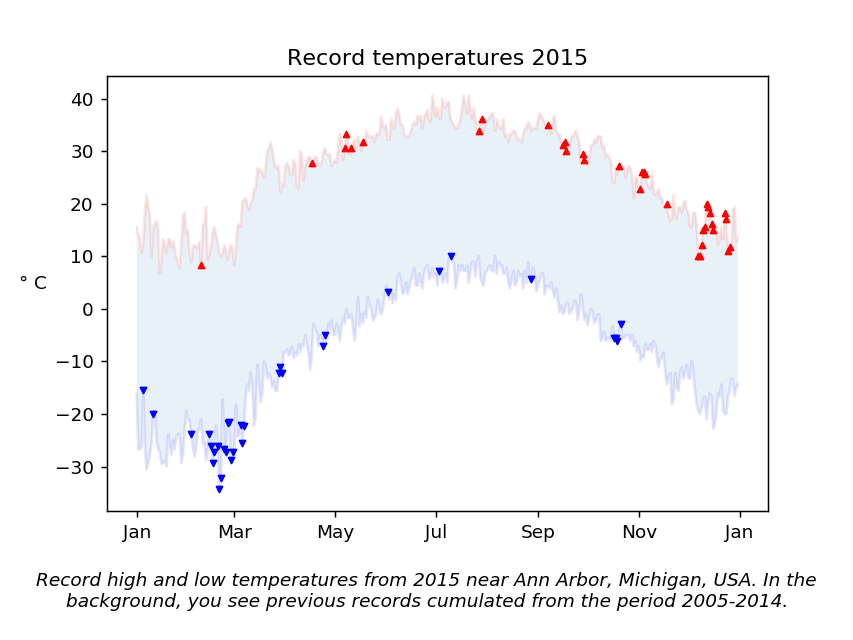

<IPython.core.display.Javascript object>

In [86]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# add scatter plot ++ get_2015()
# add alpha graying of line plot

# data
ten_years = get_period('2005-01-01', '2016-01-01')
min2015, max2015 = get_2015()
x, y1, y2 = ten_years.index, ten_years['TempMin'], ten_years['TempMax']
caption = [
    "Record high and low temperatures from 2015 near Ann Arbor, Michigan, USA. ",
    "In the background, you see previous records cumulated from the period 2005-2014."
]

# set title & caption
fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.2)
fig.text(
    0.5,
    0.05,
    "".join(caption),
    wrap=True,
    style='italic',
    horizontalalignment='center'
)
ax.set_title("Record temperatures 2015")
ax.set_ylabel(
    "$\degree$ C",
    horizontalalignment='right',
    rotation=0,
)

# line, shade & scatter
ax.plot(x, y1, 'blue', x, y2, 'red', alpha=0.1)
ax.fill_between(x, y1, y2, alpha=0.1)
ax.scatter(min2015.index, min2015.values, c='blue', marker='v', s=10)
ax.scatter(max2015.index, max2015.values, c='red', marker='^', s=10)

# xaxis date formatting
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

# save
plt.savefig('assignment2.png')